In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import os
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

In [17]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 3060 Laptop GPU


In [18]:
DATA_DIR = 'C:\\Users\\shaki\\OneDrive\\Documents\\GitHub\\FruitQuality\\FruitQuality\\label exports\\Images'
MASK_DIR = 'C:\\Users\\shaki\\OneDrive\\Documents\\GitHub\\FruitQuality\\FruitQuality\\label exports\\Masks'

In [19]:
data_ids = os.listdir(MASK_DIR)
SIZE = len(data_ids)
TRAIN_SIZE = int(0.6 * SIZE)
VAL_SIZE = int(0.2 * SIZE) # Also Test size
CLASSES = list(reversed(['seed', 'pulp', 'albedo', 'flavedo']))

In [20]:
class SemanticSegmentationDataset(Dataset):
    CLASSES = ['unlabelled', 'seed', 'pulp', 'albedo', 'flavedo']

    def __init__(
            self,
            ids,
            images_dir,
            masks_dir,
            classes=None,
            feature_extractor=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, image_id)
                           for image_id in self.ids]
        self.masks_fps = [os.path.join(
            masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(
            cls.lower()) for cls in classes]

        self.id2label = {}
        for i in range(len(classes)):
            self.id2label[self.class_values[i]] = classes[i]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.feature_extractor = feature_extractor

    def __getitem__(self, i):
        image = Image.open(self.images_fps[i])
        segmentation_map = Image.open(self.masks_fps[i])

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")
        encoded_inputs['labels'] //= 51
        encoded_inputs['labels'] -= 1

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    def __len__(self):
        return len(self.ids)

    def get_image(self, i):
        return Image.open(self.images_fps[i])

    
    def get_mask(self, i):
        return Image.open(self.masks_fps[i])


In [21]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        id2label[0]='Unlabeled'
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512",
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")

        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes,
                ignore_index=255,
                reduce_labels=False,
            )

            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k, v)

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        self.validation_step_outputs.append(loss)

        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_val_loss = torch.stack(outputs).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        self.validation_step_outputs.clear()

        return metrics

    def test_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )

        self.test_step_outputs.append(loss)

        return({'test_loss': loss})

    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack(outputs).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)

        self.test_step_outputs.clear()
        
        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl




In [22]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 128

train_dataset = SemanticSegmentationDataset(
    data_ids[:TRAIN_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    feature_extractor=feature_extractor,
)
val_dataset = SemanticSegmentationDataset(
    data_ids[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    feature_extractor=feature_extractor,
)
test_dataset = SemanticSegmentationDataset(
    data_ids[TRAIN_SIZE+VAL_SIZE:],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    feature_extractor=feature_extractor,
)

batch_size = 8
num_workers = 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,
)

C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the

In [9]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss")

trainer = pl.Trainer(
    # devices=0,
    accelerator='gpu',
    callbacks=[early_stop_callback, checkpoint_callback],
    max_epochs=10,
    val_check_interval=len(train_dataloader),
)
trainer.fit(segformer_finetuner)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 84.6 M
-----------------------------------------------------------
84.6 M    Trainable params
0         Non-trainable params
84.6 M    Total params
338.389   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\pytorch_lightning\loops\fit_loop.py:293: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at C:\Users\shaki\OneDrive\Documents\GitHub\FruitQuality\FruitQuality\expirments\pytorch citrus\lightning_logs\version_30\checkpoints\epoch=9-step=250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\shaki\OneDrive\Documents\GitHub\FruitQuality\FruitQuality\expirments\pytorch citrus\lightning_logs\version_30\checkpoints\epoch=9-step=250.ckpt
C:\Users\shaki\miniconda3\envs\fruitTorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5292838215827942
   test_mean_accuracy       0.5865867067844612
      test_mean_iou         0.5180558934490167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [29]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
    2:(0,255,0),
    3:(0,0,255),
    4:(120,120,0),
}

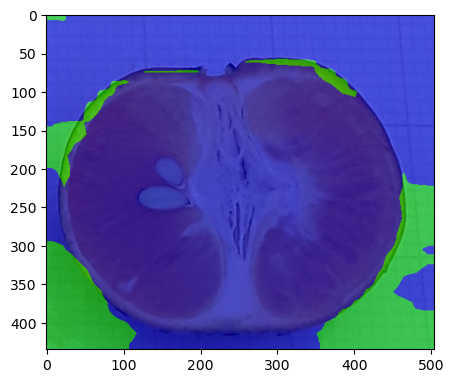

In [104]:
dataset_image = test_dataset.get_image(0)
encoded_inputs = test_dataset[0]
images, masks = encoded_inputs['pixel_values'], encoded_inputs['labels']
outputs = segformer_finetuner.model(images.unsqueeze(0), masks.unsqueeze(0))

loss, logits = outputs[0], outputs[1]

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=dataset_image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(list(color_map.values()))
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(dataset_image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.show()

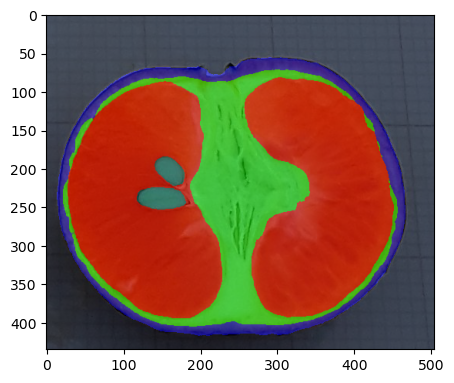

In [103]:
dataset_image = test_dataset.get_image(0)
encoded_inputs = test_dataset[0]
images, masks = encoded_inputs['pixel_values'], encoded_inputs['labels']
outputs = segformer_finetuner.model(images.unsqueeze(0), masks.unsqueeze(0))

loss, logits = outputs[0], outputs[1]

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=dataset_image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
seg = np.array(test_dataset.get_mask(0)) //51 
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(list(color_map.values()))
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(dataset_image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.show()

In [82]:
dataset_image.size

(504, 435)

In [79]:
masks.shape

torch.Size([128, 128])

In [105]:
np.unique(seg)

array([1, 2], dtype=int64)

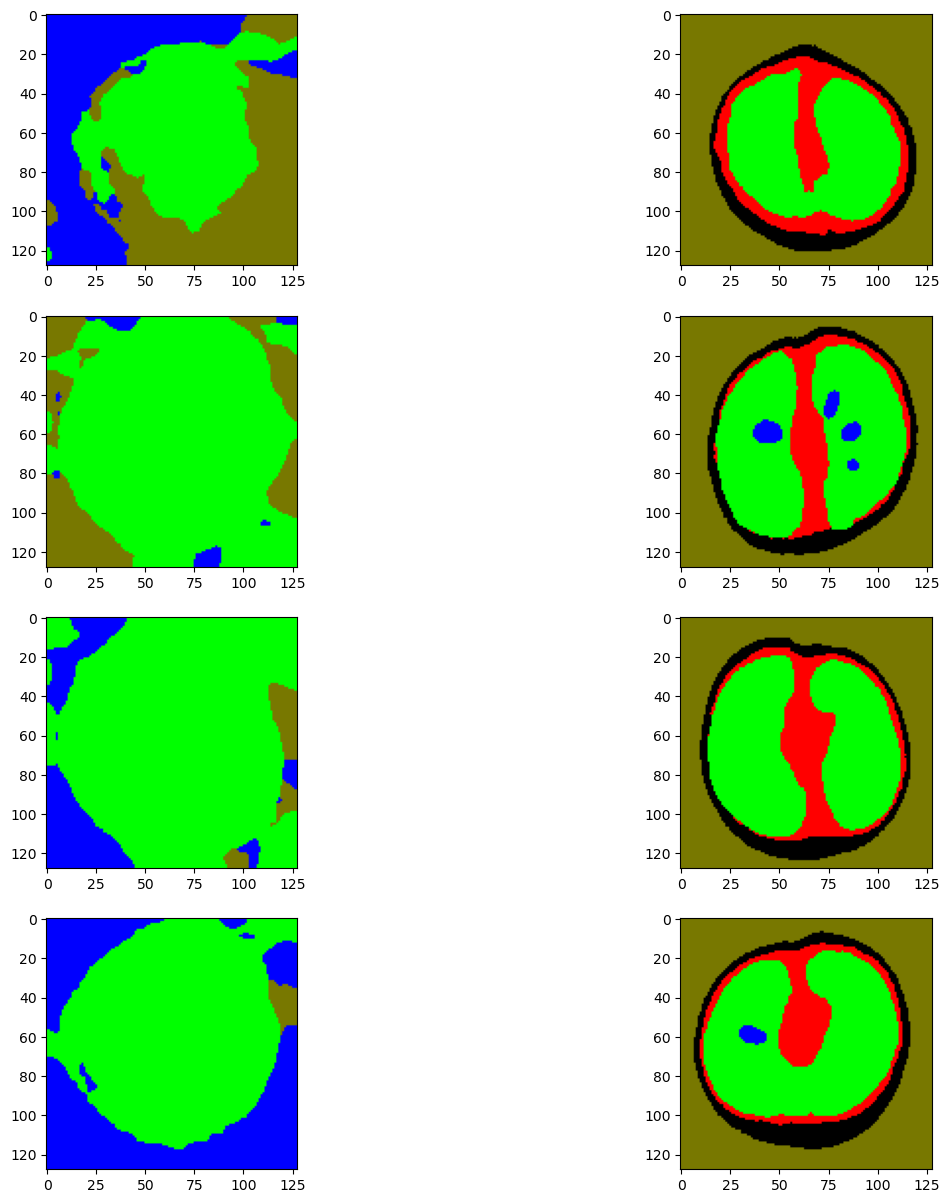

In [66]:
def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)

    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

In [23]:
import wandb

api = wandb.Api()
artifact = api.artifact('mresham/lightning_logs/model-fcm4ov60:v0', type='model')
artifact.download()

wandb: Downloading large artifact model-fcm4ov60:v0, 541.27MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.5


'C:\\Users\\shaki\\OneDrive\\Documents\\GitHub\\FruitQuality\\FruitQuality\\expirments\\pytorch citrus\\artifacts\\model-fcm4ov60-v0'

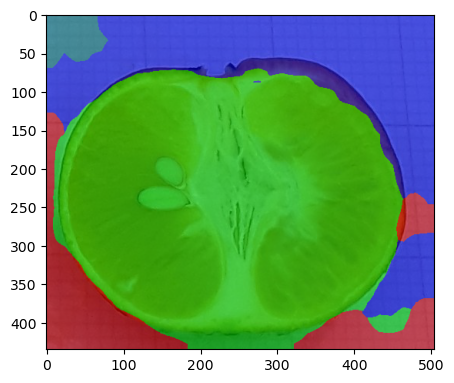

In [30]:
dataset_image = test_dataset.get_image(0)
encoded_inputs = test_dataset[0]
images, masks = encoded_inputs['pixel_values'], encoded_inputs['labels']
outputs = segformer_finetuner.model(images.unsqueeze(0), masks.unsqueeze(0))

loss, logits = outputs[0], outputs[1]

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=dataset_image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1).cpu().numpy()[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(list(color_map.values()))
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(dataset_image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(5, 10))
plt.imshow(img)
plt.show()

In [48]:
segformer_finetuner.model(images.unsqueeze(0), masks.unsqueeze(0))

(tensor(1.4486, grad_fn=<NllLoss2DBackward0>),
 tensor([[[[-0.1780, -0.2584, -0.3137,  ..., -0.0383, -0.0484, -0.0220],
           [-0.2462, -0.2950, -0.3317,  ..., -0.0390, -0.0505, -0.0338],
           [-0.2944, -0.3188, -0.3108,  ..., -0.0669, -0.0632, -0.0548],
           ...,
           [-0.4219, -0.4491, -0.4874,  ..., -0.5463, -0.5328, -0.5459],
           [-0.4597, -0.4841, -0.4720,  ..., -0.5383, -0.5481, -0.5426],
           [-0.4807, -0.4859, -0.4817,  ..., -0.5465, -0.5425, -0.5196]],
 
          [[ 0.3571,  0.3558,  0.3768,  ...,  0.6479,  0.6323,  0.6309],
           [ 0.2894,  0.3764,  0.3839,  ...,  0.6295,  0.6083,  0.5489],
           [ 0.2859,  0.4082,  0.4235,  ...,  0.5994,  0.5762,  0.5340],
           ...,
           [-0.3069, -0.2603, -0.2257,  ...,  0.1341,  0.1104,  0.1331],
           [-0.3395, -0.2720, -0.2905,  ...,  0.1227,  0.1017,  0.1017],
           [-0.2886, -0.2838, -0.2630,  ...,  0.0685,  0.0478,  0.0879]],
 
          [[-0.2065, -0.1949, -0.2163, 

In [ ]:
self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

In [45]:
SegformerForSemanticSegmentation.from_pretrained(
            os.path.abspath("./artifacts/model-fcm4ov60-v0/"),
            return_dict=False,
            num_labels=len(train_dataset.id2label.keys()),
            id2label=train_dataset.id2label,
            label2id={v:k for k,v in train_dataset.id2label.items()},
            ignore_mismatched_sizes=True,
)

OSError: C:\Users\shaki\OneDrive\Documents\GitHub\FruitQuality\FruitQuality\expirments\pytorch citrus\artifacts\model-fcm4ov60-v0 does not appear to have a file named config.json. Checkout 'https://huggingface.co/C:\Users\shaki\OneDrive\Documents\GitHub\FruitQuality\FruitQuality\expirments\pytorch citrus\artifacts\model-fcm4ov60-v0/main' for available files.

In [46]:
class SegformerForSemanticSegmentationAndImageClassification(SegformerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.segformer = SegformerModel(config)
        
        self.decode_head = SegformerDecodeHead(config)

        self.num_labels = config.num_labels
        # Classifier head
        self.classifier = nn.Linear(config.hidden_sizes[-1], config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SemanticSegmenterOutput, SegFormerImageClassifierOutput]:
        
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        outputs = self.segformer(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=True,  # we need the intermediate hidden states
            return_dict=return_dict,
        )

        encoder_hidden_states = outputs.hidden_states if return_dict else outputs[1]

        logits = self.decode_head(encoder_hidden_states)

        # Image classification stuff
        sequence_output = outputs[0]
        # convert last hidden states to (batch_size, height*width, hidden_size)
        batch_size = sequence_output.shape[0]

        if self.config.reshape_last_stage:
            # (batch_size, num_channels, height, width) -> (batch_size, height, width, num_channels)
            sequence_output = sequence_output.permute(0, 2, 3, 1)
        sequence_output = sequence_output.reshape(batch_size, -1, self.config.hidden_sizes[-1])
         # global average pooling
        sequence_output = sequence_output.mean(dim=1)
        cl_logits = self.classifier(sequence_output)
        cl_loss = None
        # Image classification stuff end

        loss = None
        if labels is not None:
            # upsample logits to the images' original size
            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            if self.config.num_labels > 1:
                loss_fct = CrossEntropyLoss(ignore_index=self.config.semantic_loss_ignore_index)
                loss = loss_fct(upsampled_logits, labels)
            elif self.config.num_labels == 1:
                valid_mask = ((labels >= 0) & (labels != self.config.semantic_loss_ignore_index)).float()
                loss_fct = BCEWithLogitsLoss(reduction="none")
                loss = loss_fct(upsampled_logits.squeeze(1), labels.float())
                loss = (loss * valid_mask).mean()
            else:
                raise ValueError(f"Number of labels should be >=0: {self.config.num_labels}")

            # Classification stuff
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            if output_hidden_states:
                output = (logits,) + outputs[1:]
            else:
                output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        # Classification Stuff
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states if output_hidden_states else None,
            attentions=outputs.attentions,
        )
        return SegFormerImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

NameError: name 'SegformerPreTrainedModel' is not defined